In [72]:
import json
import seaborn 
import seaborn as sns
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import svm
from sklearn import metrics
from sklearn.svm import SVR
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder,KBinsDiscretizer
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score,KFold,cross_val_predict
from sklearn.metrics import r2_score,mean_squared_error,roc_curve,confusion_matrix,accuracy_score

In [14]:
df = pd.read_json(path_or_buf = 'predictionQuery_Train2_withoutDelete.json', orient='records')
df
#df = pd.read_csv('predictionQuery_Train.csv')
#df.head(50)

,lon,lat,ROUTE_NUMBER,DELAY,Current_Stop,From,Destination,Direction,Current_Time,Current_Day,Current_Hour,Current_Minutes,Current_Seconds
0,20.51402,48.63529,R 812 GEMERAN,3300,Rožňava,Košice,Bratislava hlavná stanica,23,2021-03-09 10:15:39.586,9,11,15,39
1,20.51402,48.63529,R 812 GEMERAN,3420,Rožňava,Košice,Bratislava hlavná stanica,23,2021-03-09 10:17:24.584,9,11,17,24
2,20.51402,48.63529,R 812 GEMERAN,3540,Rožňava,Košice,Bratislava hlavná stanica,23,2021-03-09 10:19:39.616,9,11,19,39
3,21.95465,49.05145,Os 8915,0,Koškovce,Humenné,Medzilaborce mesto,13,2021-03-09 10:15:24.553,9,11,15,24
4,20.51402,48.63529,R 812 GEMERAN,3360,Rožňava,Košice,Bratislava hlavná stanica,23,2021-03-09 10:16:24.565,9,11,16,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8073,21.01324,48.89469,Os 7822,180,Margecany,Košice,Poprad-Tatry,9,2021-03-10 15:05:56.857,10,16,5,56
8074,21.83458,48.67913,REX 1912,0,Bánovce nad Ondavou,Humenné,Košice,10,2021-03-10 15:06:11.862,10,16,6,11
8075,21.01324,48.89469,Os 7822,180,Margecany,Košice,Poprad-Tatry,9,2021-03-10 15:06:11.862,10,16,6,11
8076,21.22393,48.85288,R 605 TATRAN,300,Kysak,Bratislava hlavná stanica,Košice,20,2021-03-10 15:06:56.865,10,16,6,56


In [15]:
df.describe()

,lon,lat,DELAY,Direction,Current_Day,Current_Hour,Current_Minutes,Current_Seconds
count,8078.000000,8078.000000,8078.000000,8078.000000,8078.000000,8078.000000,8078.000000,8078.000000
mean,21.283023,48.879886,381.228027,19.230503,9.081580,11.974127,25.121070,30.613518
std,0.476707,0.172489,1166.468912,14.478987,0.520383,5.000676,18.181324,16.759104
min,20.471821,48.390320,-240.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,20.886210,48.795800,0.000000,9.000000,9.000000,7.000000,8.000000,16.000000
50%,21.249126,48.867660,0.000000,17.000000,9.000000,13.000000,24.000000,31.000000
75%,21.751880,48.983379,300.000000,23.000000,9.000000,15.000000,40.000000,42.000000
max,22.172956,49.308340,8580.000000,72.000000,10.000000,23.000000,59.000000,59.000000


In [16]:
df.isnull().sum()

lon                0
lat                0
ROUTE_NUMBER       0
DELAY              0
Current_Stop       0
From               0
Destination        0
Direction          0
Current_Time       0
Current_Day        0
Current_Hour       0
Current_Minutes    0
Current_Seconds    0
dtype: int64

In [17]:
df.dtypes

lon                       float64
lat                       float64
ROUTE_NUMBER               object
DELAY                       int64
Current_Stop               object
From                       object
Destination                object
Direction                   int64
Current_Time       datetime64[ns]
Current_Day                 int64
Current_Hour                int64
Current_Minutes             int64
Current_Seconds             int64
dtype: object

In [18]:
corr = df.corr()#Lists all pairs of highly collinear variables
indices = np.where(corr > 0.3)
indices = [(corr.columns[x], corr.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
indices

[]

<AxesSubplot:>

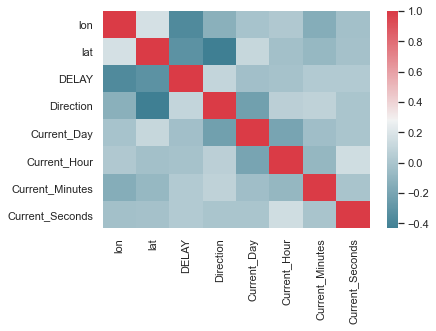

In [19]:
seaborn.set(style='white')
cmap = seaborn.diverging_palette(220, 10, as_cmap=True)
seaborn.heatmap(df.corr(),cmap=cmap)

In [20]:
df = df.drop("Current_Time",axis = 1)

In [21]:
def LabelEncoding(col):
    encoder = LabelEncoder()
    encoder.fit(df[col])
    list(encoder.classes_)
    return encoder.transform(df[col])

def KBinsDiscretizing(currCol):
    discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
    discretizer.fit(df[currCol])
    return discretizer.transform(df[currCol])

df['Current_Stop_Encoded']=LabelEncoding('Current_Stop')
df['From_Encoded']=LabelEncoding('From')
df['Destination_Encoded']=LabelEncoding('Destination')
df['lon_Encoded']=LabelEncoding('lon')
df['lat_Encoded']=LabelEncoding('lat')
df['Current_Seconds_Encoded']=LabelEncoding('Current_Seconds')
df['Current_Minutes_Encoded']=LabelEncoding('Current_Minutes')
df['Current_Hour_Encoded']= LabelEncoding('Current_Hour')
df['Current_Day_Encoded']= LabelEncoding('Current_Day')
df['ROUTE_NUMBER_Encoded'] = LabelEncoding('ROUTE_NUMBER')

In [22]:
df.head()

,lon,lat,ROUTE_NUMBER,DELAY,Current_Stop,From,Destination,Direction,Current_Day,Current_Hour,...,Current_Stop_Encoded,From_Encoded,Destination_Encoded,lon_Encoded,lat_Encoded,Current_Seconds_Encoded,Current_Minutes_Encoded,Current_Hour_Encoded,Current_Day_Encoded,ROUTE_NUMBER_Encoded
0,20.51402,48.63529,R 812 GEMERAN,3300,Rožňava,Košice,Bratislava hlavná stanica,23,9,11,...,40,7,2,2,16,39,15,9,1,258
1,20.51402,48.63529,R 812 GEMERAN,3420,Rožňava,Košice,Bratislava hlavná stanica,23,9,11,...,40,7,2,2,16,24,17,9,1,258
2,20.51402,48.63529,R 812 GEMERAN,3540,Rožňava,Košice,Bratislava hlavná stanica,23,9,11,...,40,7,2,2,16,39,19,9,1,258
3,21.95465,49.05145,Os 8915,0,Koškovce,Humenné,Medzilaborce mesto,13,9,11,...,15,5,11,58,56,24,15,9,1,144
4,20.51402,48.63529,R 812 GEMERAN,3360,Rožňava,Košice,Bratislava hlavná stanica,23,9,11,...,40,7,2,2,16,24,16,9,1,258


In [23]:
df = df.drop(['ROUTE_NUMBER','Current_Stop','Current_Hour','Current_Minutes',
              'Current_Seconds','lon','lat',"Destination","From",
              'Current_Day'],axis =1, errors='ignore')

,DELAY,Direction,Current_Stop_Encoded,From_Encoded,Destination_Encoded,lon_Encoded,lat_Encoded,Current_Seconds_Encoded,Current_Minutes_Encoded,Current_Hour_Encoded,Current_Day_Encoded,ROUTE_NUMBER_Encoded
0,3300,23,40,7,2,2,16,39,15,9,1,258
1,3420,23,40,7,2,2,16,24,17,9,1,258
2,3540,23,40,7,2,2,16,39,19,9,1,258
3,0,13,15,5,11,58,56,24,15,9,1,144
4,3360,23,40,7,2,2,16,24,16,9,1,258
5,3420,23,40,7,2,2,16,39,17,9,1,258
6,3480,23,40,7,2,2,16,24,18,9,1,258
7,0,1,53,13,5,57,47,54,18,9,1,143
8,0,7,29,16,9,11,27,54,19,9,1,25
9,3600,23,40,7,2,2,16,24,20,9,1,258


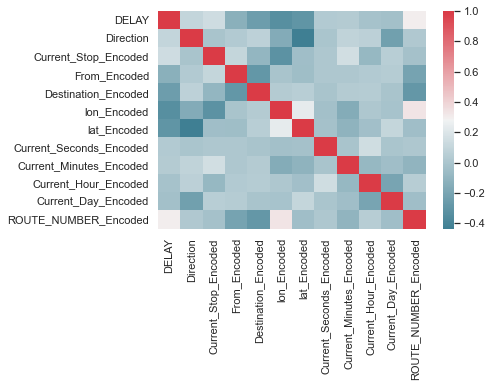

In [24]:
seaborn.heatmap(df.corr(),cmap=cmap)
df.head(10)

In [25]:
corr = df.corr()#Lists all pairs of highly collinear variables
indices = np.where(corr > 0.3)
indices = [(corr.columns[x], corr.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
indices

[('DELAY', 'ROUTE_NUMBER_Encoded'), ('lon_Encoded', 'ROUTE_NUMBER_Encoded')]

In [26]:
corr = df.corr()#Lists all pairs of highly collinear variables
indices = np.where(corr < -0.3)
indices = [(corr.columns[x], corr.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
indices

[('DELAY', 'lon_Encoded'),
 ('Direction', 'lat_Encoded'),
 ('Current_Stop_Encoded', 'lon_Encoded')]

In [27]:
df = df.drop(['lon_Encoded','lat_Encoded','From_Encoded'],axis =1, errors='ignore')

In [28]:
corr = df.corr()#Lists all pairs of highly collinear variables
indices = np.where(corr > 0.3)
indices = [(corr.columns[x], corr.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
indices

[('DELAY', 'ROUTE_NUMBER_Encoded')]

In [29]:
corr = df.corr()#Lists all pairs of highly collinear variables
indices = np.where(corr < -0.3)
indices = [(corr.columns[x], corr.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
indices

[]

<Figure size 6000x3000 with 0 Axes>

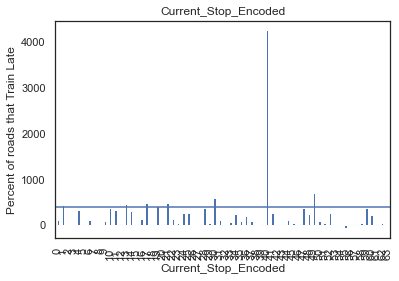

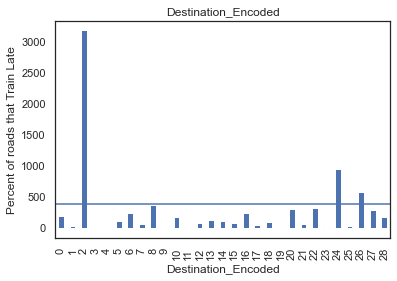

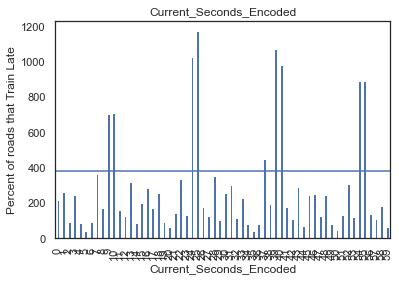

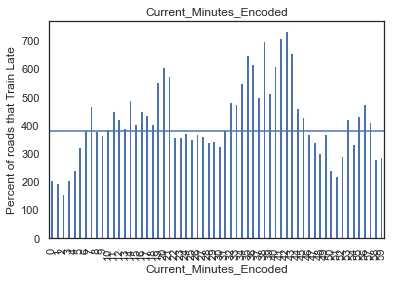

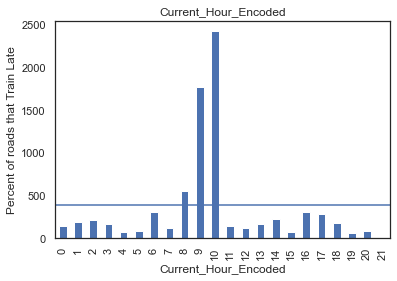

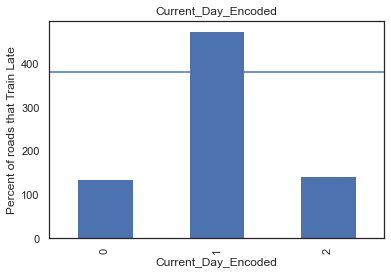

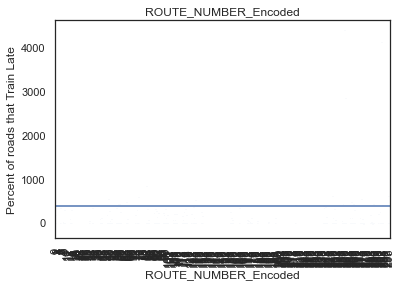

In [30]:
avgLate = np.sum(df['DELAY'])/len(df['DELAY'])
attributes = ['Current_Stop_Encoded','Destination_Encoded',
              'Current_Seconds_Encoded','Current_Minutes_Encoded','Current_Hour_Encoded',
              'Current_Day_Encoded','ROUTE_NUMBER_Encoded']
for i,pred in enumerate(attributes):
    plt.figure(i, figsize=(20, 10),dpi=300)
    group = df.groupby([pred], as_index=False).aggregate(np.mean)[[pred, 'DELAY']]
    group.sort_values(by=pred, inplace=True)    
    group.plot.bar(x=pred, y='DELAY')
    plt.axhline(y=avgLate, label='Average')
    plt.ylabel('Percent of roads that Train Late')
    plt.title(pred)
    plt.legend().remove()

In [31]:
train_x, test_x, train_y, test_y = train_test_split(df.drop('DELAY', axis=1), df['DELAY'], test_size=0.3, random_state=1234)

In [32]:
print(train_x.shape +  test_x.shape)

(5654, 8, 2424, 8)


In [33]:
print(train_y.shape +  test_y.shape)

(5654, 2424)


#### GridSearch for RandomForest

In [34]:
startTimeGS = datetime.now()
param_grid = {'n_estimators': [10,15,20,25,100,500,600,700,800,900,1000]}

grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=10)
grid_rf.fit(train_x, train_y)
bestModel = grid_rf.best_estimator_
bestParameters = grid_rf.best_params_
gridScores = grid_rf.score
print('Random forest Grid Search with non-redundant variables took [', datetime.now() - startTimeGS, '] seconds.')

Random forest Grid Search with non-redundant variables took [ 0:13:32.738418 ] seconds.


In [35]:
print(bestModel)
print(bestParameters)
gridScores

RandomForestRegressor(n_estimators=25)
{'n_estimators': 25}


<bound method BaseSearchCV.score of GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'n_estimators': [10, 15, 20, 25, 100, 500, 600, 700,
                                          800, 900, 1000]})>

#### RandomForest

In [36]:
regr = RandomForestRegressor(n_estimators = bestParameters.get('n_estimators'),
                             random_state = 1234)
model = regr.fit(train_x, train_y)
folds = KFold(n_splits = 10, shuffle = True, random_state = 1234)
scores = cross_val_score(regr, df.drop('DELAY', axis=1), df['DELAY'], cv=folds,scoring='r2')
y_pred = cross_val_predict(regr, df.drop('DELAY', axis=1), df['DELAY'], cv=folds)
print(scores.mean())
print(scores.std())
print(scores)


y_pred_Random_Forrest = regr.predict(test_x)
regr.score(test_x,test_y)

0.9979590076088842
0.0015608346968797968
[0.99761799 0.99910455 0.99681392 0.99857482 0.99916013 0.99374923
 0.99831009 0.9989093  0.99856004 0.99879001]


0.9948986761246253

In [37]:
y_pred= y_pred_Random_Forrest
y_true=test_y
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred_Random_Forrest))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred_Random_Forrest))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_true, y_pred_Random_Forrest, squared=False))
print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred_Random_Forrest))
print('Max Error:', metrics.max_error(y_true, y_pred_Random_Forrest))
print('Median Absolute Error:', metrics.median_absolute_error(y_true, y_pred_Random_Forrest))
print('R^2:', metrics.r2_score(y_true, y_pred_Random_Forrest))

Mean Absolute Error (MAE): 21.89207920792079
Mean Squared Error (MSE): 7262.0269306930695
Root Mean Squared Error (RMSE): 85.21752713317296
Explained Variance Score: 0.9948989182786443
Max Error: 2390.4
Median Absolute Error: 0.0
R^2: 0.9948986761246253


<AxesSubplot:title={'center':'Residuals'}, xlabel='DELAY', ylabel='DELAY'>

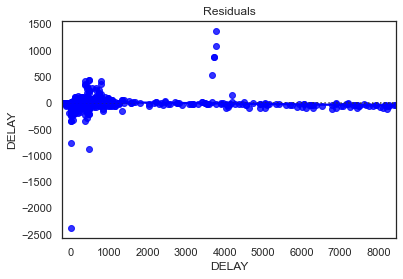

In [38]:
residuals = test_y - y_pred
plt.title('Residuals')
sns.residplot(x=test_y, y=residuals, lowess=True, color="blue")

Text(0.5, 1.0, 'Actual vs predicted')

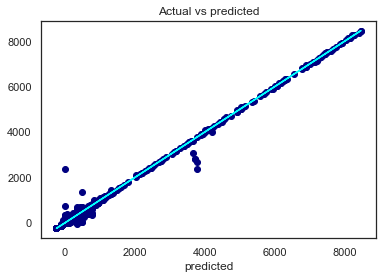

In [39]:
y_pred= regr.predict(test_x)
residuals = test_y - y_pred
plt.scatter(x=test_y, y=y_pred,color = 'navy')
plt.plot(test_y, test_y,color = 'cyan')
plt.xlabel('Actual')
plt.xlabel('predicted')
plt.title('Actual vs predicted')

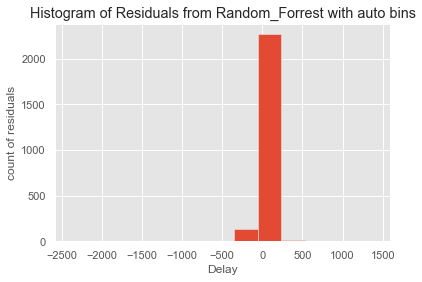

In [40]:
plt.style.use('ggplot')
plt.ylabel('count of residuals')
plt.xlabel('Delay')
plt.hist(residuals, bins='auto')
plt.title("Histogram of Residuals from Random_Forrest with auto bins")
plt.show()

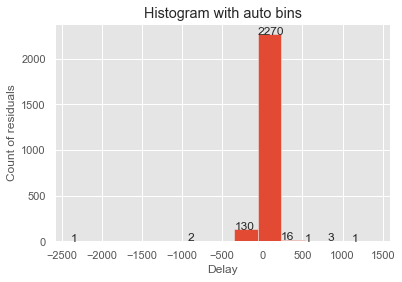

In [41]:
plt.style.use('ggplot')
plt.ylabel('Count of residuals')
plt.xlabel('Delay')
plt.title("Histogram with auto bins")
density, bins, _ = plt.hist(residuals, bins='auto')
count, _ = np.histogram(residuals, bins)
for x,y,num in zip(bins, density, count):
    if num != 0:
        plt.text(x, y+0.05, num, fontsize=12, rotation=0) # x,y,str

#### GridSearch for Linear Regression

In [42]:
param_grid = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True,False]}
grid_search = GridSearchCV(LinearRegression(), param_grid, cv = 10)
grid_search.fit(train_x, train_y)

bestModel = grid_search.best_estimator_
bestParameters = grid_search.best_params_
gridScores = grid_search.score
print(bestModel)
print(bestParameters)
gridScores

LinearRegression()
{'copy_X': True, 'fit_intercept': True, 'normalize': False}


<bound method BaseSearchCV.score of GridSearchCV(cv=10, estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]})>

#### LinearRegression

In [43]:
regressor = LinearRegression(fit_intercept=bestParameters.get('fit_intercept'),
                             normalize=bestParameters.get('normalize'), 
                             copy_X=bestParameters.get('copy_X'))  
regressor.fit(train_x, train_y)
folds = KFold(n_splits = 10, shuffle = True, random_state = 1234)
scores = cross_val_score(regressor, df.drop('DELAY', axis=1), df['DELAY'], cv=folds,scoring='r2')
y_pred = cross_val_predict(regressor, df.drop('DELAY', axis=1), df['DELAY'], cv=folds)
print(scores.mean())
print(scores.std())
print(scores)


y_pred_Linear_Regression = regressor.predict(test_x)
regressor.score(test_x,test_y)

0.14778396697893287
0.018809249634176683
[0.14452648 0.1696475  0.14073451 0.13259511 0.15786273 0.1224409
 0.18647625 0.15620356 0.13910637 0.12824627]


0.1524277072693344

In [44]:
y_pred= y_pred_Linear_Regression
y_true=test_y
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_true, y_pred, squared=False))
print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
print('Max Error:', metrics.max_error(y_true, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(y_true, y_pred))
print('R^2:', metrics.r2_score(y_true, y_pred))

Mean Absolute Error (MAE): 581.0901272305731
Mean Squared Error (MSE): 1206567.7392552083
Root Mean Squared Error (RMSE): 1098.4387735578202
Explained Variance Score: 0.1526322841540919
Max Error: 7246.869833817982
Median Absolute Error: 371.02012537754524
R^2: 0.1524277072693344


<AxesSubplot:title={'center':'Residuals'}, xlabel='DELAY', ylabel='DELAY'>

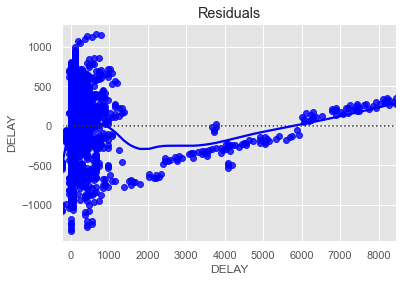

In [45]:
residuals = test_y - y_pred
plt.title('Residuals')
sns.residplot(x=test_y, y=residuals, lowess=True, color="blue")

Text(0.5, 1.0, 'Actual vs predicted')

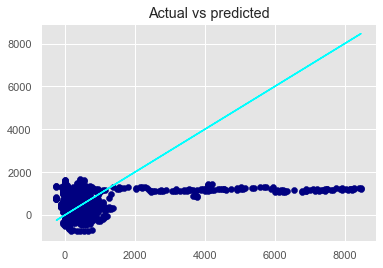

In [46]:
y_pred= regressor.predict(test_x)
residuals = test_y - y_pred
plt.scatter(x=test_y, y=y_pred,color = 'navy')
plt.plot(test_y, test_y,color = 'cyan')
plt.title('Actual vs predicted')

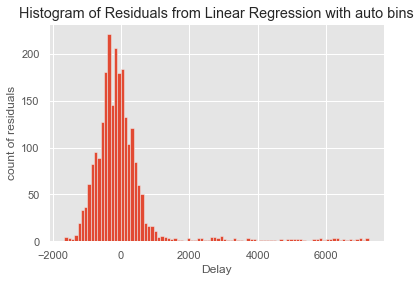

In [47]:
plt.style.use('ggplot')
plt.ylabel('count of residuals')
plt.xlabel('Delay')
plt.hist(residuals, bins='auto')
plt.title("Histogram of Residuals from Linear Regression with auto bins")
plt.show()

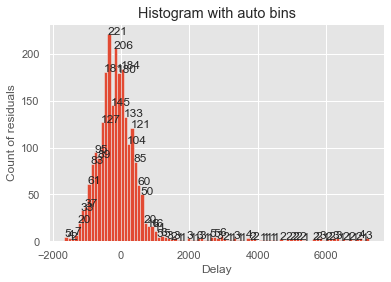

In [48]:
plt.style.use('ggplot')
plt.ylabel('Count of residuals')
plt.xlabel('Delay')
plt.title("Histogram with auto bins")
density, bins, _ = plt.hist(residuals, bins='auto')
count, _ = np.histogram(residuals, bins)
for x,y,num in zip(bins, density, count):
    if num != 0:
        plt.text(x, y+0.05, num, fontsize=12, rotation=0) # x,y,str

#### GridsearchCV for SVR

In [49]:
param_grid = {'C': [0.001, 0.01, 10, 100,1.0], 'gamma' : [0.001, 0.01, 0.1,1.0,'scale']}
grid_search = GridSearchCV(SVR(), param_grid, cv = 10)
grid_search.fit(train_x, train_y)

bestModel = grid_search.best_estimator_
bestParameters = grid_search.best_params_
gridScores = grid_search.score
print(bestModel)
print(bestParameters)
gridScores

SVR(C=100, gamma=0.001)
{'C': 100, 'gamma': 0.001}


<bound method BaseSearchCV.score of GridSearchCV(cv=10, estimator=SVR(),
             param_grid={'C': [0.001, 0.01, 10, 100, 1.0],
                         'gamma': [0.001, 0.01, 0.1, 1.0, 'scale']})>

#### SVR

In [50]:
svr_rbf = SVR(kernel='rbf', 
              C=bestParameters.get('C'),
              gamma=bestParameters.get('gamma'), epsilon=1)
svr_rbf.fit(train_x, train_y)
folds = KFold(n_splits = 10, shuffle = True, random_state = 1234)
scores = cross_val_score(svr_rbf, df.drop('DELAY', axis=1), df['DELAY'], cv=folds,scoring='r2')
y_pred = cross_val_predict(svr_rbf, df.drop('DELAY', axis=1), df['DELAY'], cv=folds)
print(scores.mean())
print(scores.std())
print(scores)
y_pred_svr_rbf = svr_rbf.predict(test_x)
svr_rbf.score(test_x,test_y)

0.5249772156290604
0.024179837340049457
[0.54545697 0.51194724 0.52771988 0.57613171 0.51395497 0.52348474
 0.50641665 0.52086282 0.48184947 0.54194771]


0.48300925878575496

In [51]:
y_pred= y_pred_svr_rbf
y_true=test_y
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_true, y_pred, squared=False))
print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
print('Max Error:', metrics.max_error(y_true, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(y_true, y_pred))
print('R^2:', metrics.r2_score(y_true, y_pred))

Mean Absolute Error (MAE): 264.5022308769623
Mean Squared Error (MSE): 735965.9526305055
Root Mean Squared Error (RMSE): 857.8845800167442
Explained Variance Score: 0.49813511567775426
Max Error: 6746.819723449924
Median Absolute Error: 20.712738917942758
R^2: 0.48300925878575496


<AxesSubplot:title={'center':'Residuals'}, xlabel='DELAY', ylabel='DELAY'>

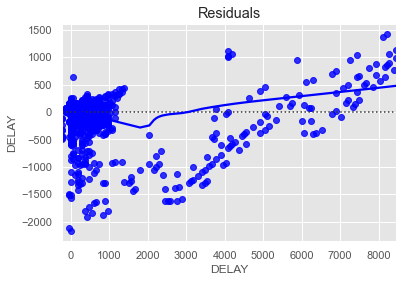

In [52]:
residuals = test_y - y_pred
plt.title('Residuals')
sns.residplot(x=test_y, y=residuals, lowess=True, color="blue")

Text(0.5, 1.0, 'Actual vs predicted')

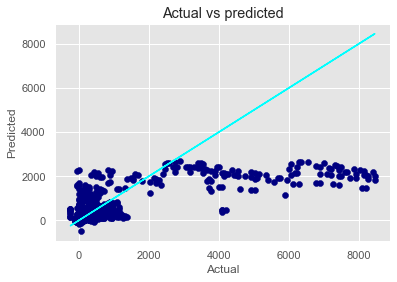

In [53]:
y_pred= svr_rbf.predict(test_x)
residuals = test_y - y_pred
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.scatter(x=test_y, y=y_pred,color = 'navy')
plt.plot(test_y, test_y,color = 'cyan')
plt.title('Actual vs predicted')

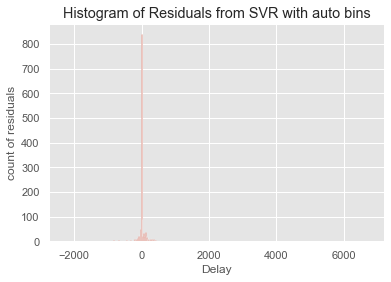

In [54]:
plt.style.use('ggplot')
plt.ylabel('count of residuals')
plt.xlabel('Delay')
plt.hist(residuals, bins='auto')
plt.title("Histogram of Residuals from SVR with auto bins")
plt.show()

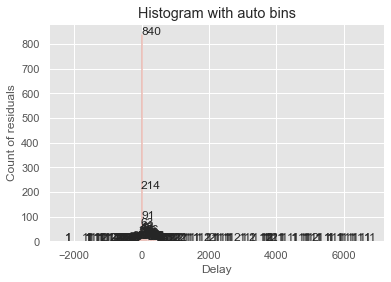

In [55]:
plt.style.use('ggplot')
plt.ylabel('Count of residuals')
plt.xlabel('Delay')
plt.title("Histogram with auto bins")
density, bins, _ = plt.hist(residuals, bins='auto')
count, _ = np.histogram(residuals, bins)
for x,y,num in zip(bins, density, count):
    if num != 0:
        plt.text(x, y+0.05, num, fontsize=12, rotation=0) # x,y,str

#### GridSearch for XGBoost model

In [56]:
param_grid = {'max_depth' : [1,2,3,4,5,6,7,8,9,10],
              'n_estimators': [10,15,20,25,100,500,600,700,800,900,1000]
             }
grid_search = GridSearchCV(xgb.XGBRegressor(objective ='reg:squarederror'), param_grid, cv = 10)
grid_search.fit(train_x, train_y)

bestModel = grid_search.best_estimator_
bestParameters = grid_search.best_params_
gridScores = grid_search.score
print(bestModel)
print(bestParameters)
gridScores

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
{'max_depth': 3, 'n_estimators': 1000}


<bound method BaseSearchCV.score of GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                              

#### XGBoost model

In [57]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                          colsample_bytree = 0.8, 
                          learning_rate = 1,
                          max_depth = bestParameters.get('max_depth'), 
                          alpha = 10, 
                          n_estimators = bestParameters.get('n_estimators'))
xg_reg.fit(train_x,train_y)
folds = KFold(n_splits = 10, shuffle = True, random_state = 1234)
scores= cross_val_score(xg_reg, df.drop('DELAY', axis=1), df['DELAY'], cv=folds,scoring='r2')
y_pred = cross_val_predict(xg_reg, df.drop('DELAY', axis=1), df['DELAY'], cv=folds)
print(scores.mean())
print(scores.std())
print(scores)

y_pred_xg_reg = xg_reg.predict(test_x)
rmse = np.sqrt(mean_squared_error(test_y, y_pred_xg_reg))
print(xg_reg.score(test_x,test_y))

0.9957862128871126
0.003084569267345029
[0.99670427 0.99828356 0.99104165 0.98877815 0.99877864 0.99637447
 0.99743004 0.99711656 0.99594211 0.99741268]
0.99687149576432


In [58]:
y_pred= y_pred_xg_reg
y_true=test_y
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_true, y_pred, squared=False))
print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
print('Max Error:', metrics.max_error(y_true, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(y_true, y_pred))
print('R^2:', metrics.r2_score(y_true, y_pred))

Mean Absolute Error (MAE): 35.43986931169043
Mean Squared Error (MSE): 4453.605096897879
Root Mean Squared Error (RMSE): 66.73533619378776
Explained Variance Score: 0.9968720467456338
Max Error: 1118.56787109375
Median Absolute Error: 19.96830463409424
R^2: 0.99687149576432


<AxesSubplot:title={'center':'Residuals'}, xlabel='DELAY', ylabel='DELAY'>

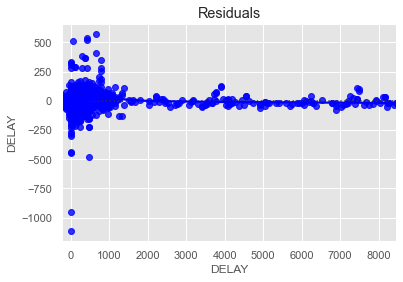

In [59]:
residuals = test_y - y_pred
plt.title('Residuals')
sns.residplot(x=test_y, y=residuals, lowess=True, color="blue")

Text(0.5, 1.0, 'Actual vs predicted')

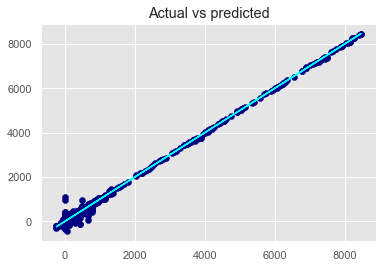

In [60]:
y_pred= xg_reg.predict(test_x)
residuals = test_y - y_pred
plt.scatter(x=test_y, y=y_pred,color = 'navy')
plt.plot(test_y, test_y,color = 'cyan')
plt.title('Actual vs predicted')

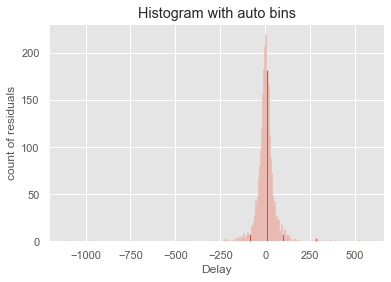

In [61]:
plt.style.use('ggplot')
plt.ylabel('count of residuals')
plt.xlabel('Delay')
plt.hist(residuals, bins='auto')
plt.title("Histogram with auto bins")
plt.show()

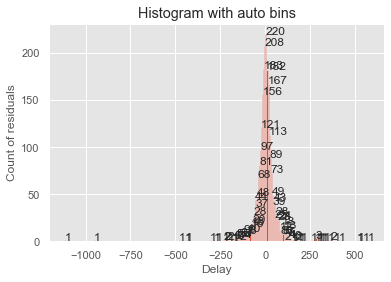

In [62]:
plt.style.use('ggplot')
plt.ylabel('Count of residuals')
plt.xlabel('Delay')
plt.title("Histogram with auto bins")
density, bins, _ = plt.hist(residuals, bins='auto')
count, _ = np.histogram(residuals, bins)
for x,y,num in zip(bins, density, count):
    if num != 0:
        plt.text(x, y+0.05, num, fontsize=12, rotation=0) # x,y,str

In [63]:
residuals.describe()

count    2424.000000
mean        0.885637
std        66.743228
min     -1118.567871
25%       -19.677216
50%         1.097123
75%        20.159645
max       576.311157
Name: DELAY, dtype: float64

#### GridSearch for DecisionTree

In [64]:
startTimeGS = datetime.now()
param_grid = {'criterion':['mse', 'friedman_mse', 'mae'],
              'splitter':['best','random']}

grid_rf = GridSearchCV(DecisionTreeRegressor(random_state =  0), param_grid, cv=10)
grid_rf.fit(train_x, train_y)
bestModel = grid_rf.best_estimator_
bestParameters = grid_rf.best_params_
gridScores = grid_rf.score
print('MLPRegressor Grid Search with non-redundant variables took [', datetime.now() - startTimeGS, '] seconds.')

MLPRegressor Grid Search with non-redundant variables took [ 0:00:29.471461 ] seconds.


In [65]:
print(bestModel)
print(bestParameters)
gridScores

DecisionTreeRegressor(random_state=0)
{'criterion': 'mse', 'splitter': 'best'}


<bound method BaseSearchCV.score of GridSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=0),
             param_grid={'criterion': ['mse', 'friedman_mse', 'mae'],
                         'splitter': ['best', 'random']})>

In [66]:
regr = DecisionTreeRegressor(criterion = bestParameters.get('criterion'),
                             splitter = bestParameters.get('splitter'))
regr.fit(train_x, train_y)
folds = KFold(n_splits = 10, shuffle = True, random_state = 1234)
scores = cross_val_score(regr, df.drop('DELAY', axis=1), df['DELAY'], cv=folds,scoring='r2')
y_pred = cross_val_predict(regr, df.drop('DELAY', axis=1), df['DELAY'], cv=folds)
print(scores.mean())
print(scores.std())
print(scores)


y_pred_regr = regr.predict(test_x)
regr.score(test_x,test_y)

0.9982482417607953
0.0008192190083712242
[0.99591852 0.99868444 0.99882129 0.998342   0.99895582 0.99822683
 0.99868847 0.99847554 0.99815734 0.99821218]


0.9969912217339001

In [67]:
y_pred= y_pred_regr
y_true=test_y
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_true, y_pred, squared=False))
print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
print('Max Error:', metrics.max_error(y_true, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(y_true, y_pred))
print('R^2:', metrics.r2_score(y_true, y_pred))

Mean Absolute Error (MAE): 14.801980198019802
Mean Squared Error (MSE): 4283.168316831683
Root Mean Squared Error (RMSE): 65.44591902350889
Explained Variance Score: 0.9969933306455785
Max Error: 720.0
Median Absolute Error: 0.0
R^2: 0.9969912217339001


<AxesSubplot:title={'center':'Residuals'}, xlabel='DELAY', ylabel='DELAY'>

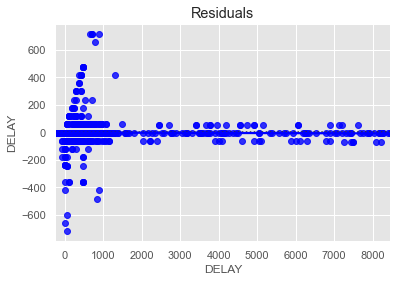

In [68]:
residuals = test_y - y_pred
plt.title('Residuals')
sns.residplot(x=test_y, y=residuals, lowess=True, color="blue")

Text(0.5, 1.0, 'Actual vs predicted')

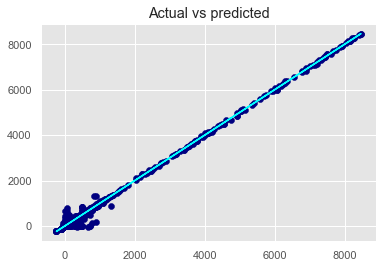

In [69]:
y_pred= regr.predict(test_x)
residuals = test_y - y_pred
plt.scatter(x=test_y, y=y_pred,color = 'navy')
plt.plot(test_y, test_y,color = 'cyan')
plt.title('Actual vs predicted')

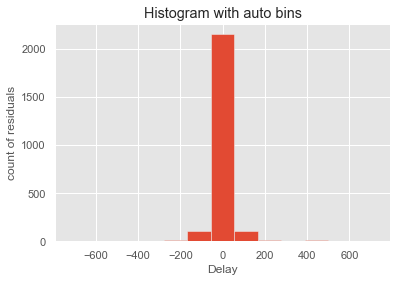

In [70]:
plt.style.use('ggplot')
plt.ylabel('count of residuals')
plt.xlabel('Delay')
plt.hist(residuals, bins='auto')
plt.title("Histogram with auto bins")
plt.show()

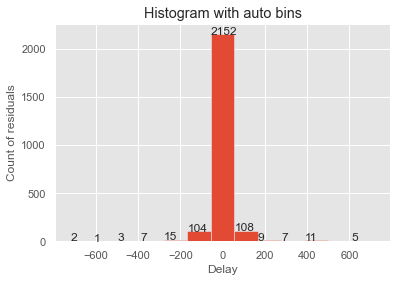

In [71]:
plt.style.use('ggplot')
plt.ylabel('Count of residuals')
plt.xlabel('Delay')
plt.title("Histogram with auto bins")
density, bins, _ = plt.hist(residuals, bins='auto')
count, _ = np.histogram(residuals, bins)
for x,y,num in zip(bins, density, count):
    if num != 0:
        plt.text(x, y+0.05, num, fontsize=12, rotation=0) # x,y,str